In [23]:
import project_path

import matplotlib.pyplot as plt
from copy import deepcopy
import os
import re
import pandas as pd
import seaborn as sns
import sqlite3 as sl
from tqdm import tqdm
from typing import List, Any, Tuple, Dict

from lib.detectors import KS_Detector
from lib.inspector import Inspector
from lib.inspector import OneNightStandInspector
from lib.qmt import execute_programs
from lib.utils import iterate_over
from lib.utils import load_config_and_check
from lib.inspector import retrieve_relevant_file_paths
from lib.inspector import inspec_column_of
from lib.inspector import read_program
from lib.inspector import create_folder_in_interesting_cases
from lib.inspector import copy_bug

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import json
import ast

In [25]:
ALL_MR_NAMES = [
    "AddUnusedRegister",
    "ChangeBackend",
    "ChangeCouplingMap",
    "ChangeOptLevel",
    "ChangeQubitOrder",
    "ChangeTargetBasis",
    "InjectNullEffect",
    "InjectParameters",
    "RunIndependentPartitions",
    "ToQasmAndBack",
    "QdiffG1SwapToCnot",
    "QdiffG2TwoHToId",
    "QdiffG3XToHSSH",
    "QdiffG4ZtoSS",
    "QdiffG5CZtoHCnotH",
    "QdiffG6TwoCzToId",
    "QdiffG7CCNOTDecomposition"
]

OUT_FOLDER = "../data/paper_images"
COL_TRANSF = "followup.metamorphic_transformations"
PVAL_COL = "divergence.ks.p-value"
ALPHA_LEVEL = 0.05

MR_ALIAS = {
    "ChangeTargetBasis": "ChangeOfGateSet",
    "ToQasmAndBack": "Roundtrip conversion via QASM",
    "ChangeBackend": "Change of backend",
    "ChangeCouplingMap": "Change of coupling map",
    "ChangeOptLevel": "Change of optimization level",
    "ChangeTargetBasis": "Change of gate set",
    "ChangeQubitOrder": "Change of qubit order",
    "RunIndependentPartitions": "Partitioned execution",
    "InjectNullEffect": "Inject null-effect operations",
    "AddUnusedRegister": "Add quantum register",
    "InjectParameters": "Inject parameters",
    
}

# Read Data

In [26]:
def read_coverage(experiment_name: str):
    """Read the coverage information for the given experiment.
    
    Return:
    - df_coverage: pd.DataFrame with columns
        "n_programs": int number of programs run so far.
        "percent_covered": float percentage code coverage corresponding to 
        the n_programs
        "exp_name": str repeated experiment_name
    Note that the two array will have the same size.        
    """
    exp_path = os.path.join("..", "data", experiment_name, "coverage_reports")
    cov_reports = os.listdir(exp_path)
    reports = []
    for cov_report in cov_reports:
        c_report = {}
        c_report["experiment_name"] = experiment_name
        path_report = os.path.join(exp_path, cov_report)
        c_report["n_programs"] = int(cov_report.replace(".json", ""))
        report_data = json.load(open(path_report, 'r'))
        c_report["percent_covered"] = report_data["totals"]["percent_covered"]
        reports.append(c_report)
    return pd.DataFrame.from_records(reports).sort_values(by="n_programs")


def read_data_and_warnings(experiment_name: str):
    """Read the datase of the warnings found during the experiment."""
    sql_path = os.path.join("..", "data", experiment_name, "qfl.db")
    sql_conn = sl.connect(sql_path)
    # LOAD DATA
    df_data = pd.read_sql("""SELECT * from QFLDATA""", sql_conn)
    df_data["experiment_name"] = experiment_name
    print(f"Total (potentially divergent) comparisons: {len(df_data)}")
    try:
        df_crash = pd.read_sql("""SELECT * from CRASHDATA""", sql_conn)
        print(f"Total crash in programs: {len(df_crash)}")
        print(f"\tcrashing source: {len(df_crash[~df_crash['exceptions.source'].isna()])}")
        print(f"\tcrashing follow-up: {len(df_crash[~df_crash['exceptions.followup'].isna()])}")
        df_crash["experiment_name"] = experiment_name
    except Exception as e:
        df_crash = pd.DataFrame()
        print("No crash data")
    
    return df_data, df_crash

In [27]:
EXP_FOLDERS_QDIFF = ["qmt_v50"]
EXP_FOLDERS_MORPHQ = ["qmt_v51"]

In [28]:
#EXP_FOLDERS_QDIFF = ["qmt_v30", "qmt_v31"]
#EXP_FOLDERS_MORPHQ = ["qmt_v40", "qmt_v41"]

#EXP_FOLDERS_QDIFF = ["qmt_v" + str(i) for i in range(30, 40)]
#print("EXP_FOLDERS_QDIFF: ", EXP_FOLDERS_QDIFF)
#EXP_FOLDERS_MORPHQ = ["qmt_v" + str(i) for i in range(40, 50)]
#print("EXP_FOLDERS_MORPHQ: ", EXP_FOLDERS_MORPHQ)


In [29]:
df_all_cov = []
df_all_data = []
df_all_crash = []
    
for approach, exp_folders in zip(
        ["qdiff", "morphq"],
        [EXP_FOLDERS_QDIFF, EXP_FOLDERS_MORPHQ]):
    for exp_folder in exp_folders:
        df_cov = read_coverage(experiment_name=exp_folder)
        df_cov["approach"] = approach
        df_data, df_crash = read_data_and_warnings(experiment_name=exp_folder)
        df_data["approach"] = approach
        df_crash["approach"] = approach
        df_all_cov.append(df_cov)        
        df_all_data.append(df_data)
        df_all_crash.append(df_crash) 
    

Total (potentially divergent) comparisons: 41510
No crash data
Total (potentially divergent) comparisons: 11278
Total crash in programs: 4827
	crashing source: 0
	crashing follow-up: 4827


In [30]:
df_data_both = pd.concat(df_all_data, axis=0).reset_index()
df_crash_both = pd.concat(df_all_crash, axis=0).reset_index()

In [31]:
df_generated_programs_both = pd.concat(
    [
        df_data_both.assign(generated_a_crash=False),
        df_crash_both.assign(generated_a_crash=True)
    ],
    axis=0
)

In [32]:
n_warinings_qdiff = len(df_generated_programs_both[
    (df_generated_programs_both["generated_a_crash"] == True) &
    (df_generated_programs_both["approach"] == "qdiff")
])
print(f"Qdiff found {n_warinings_qdiff} warnings")

Qdiff found 0 warnings


# RQ 1 - Table - MorphQ Statistics: Tot vs Crashing

In [10]:
INCLUDE_DISTRIB_DIFF = True

df_morphq = df_generated_programs_both[
    df_generated_programs_both["approach"] == "morphq"
]
df_morphq = df_morphq.drop_duplicates(subset=["program_id"])
df_morphq_crash = df_morphq[df_morphq["generated_a_crash"]]
df_morphq_no_crash = df_morphq[~df_morphq["generated_a_crash"]]

print(f"In the first 2 days we tested {len(df_morphq)} program pairs")

n_tot_pairs = len(df_morphq)
n_crash = len(df_morphq_crash)
n_complete_execution = len(df_morphq_no_crash)
assert n_crash + n_complete_execution == n_tot_pairs

perc_crash = (n_crash / n_tot_pairs) * 100
perc_complete_execution = (n_complete_execution / n_tot_pairs) * 100

print(f"{n_crash} ({perc_crash:.2f} %) crashes")
print(f"{n_complete_execution} ({perc_complete_execution:.2f} %) complete executions")

n_crash_source = len(df_morphq_crash[~df_morphq_crash['exceptions.source'].isna()])
n_crash_followup = len(df_morphq_crash[~df_morphq_crash['exceptions.followup'].isna()]) 
perc_crash_source = (n_crash_source / n_tot_pairs) * 100
perc_crash_followup = (n_crash_followup / n_tot_pairs) * 100

n_divergence = len(df_morphq[df_morphq[PVAL_COL] < ALPHA_LEVEL])
perc_divergence = (n_divergence / n_tot_pairs) * 100

print("% RQ1 " + str(EXP_FOLDERS_MORPHQ))
print("\\newcommand{\percCrashesBenchmark}{"+f"{perc_crash:.1f}"+"\%}")
print("\\newcommand{\\totalTestedProgramPairs}{"+f"{n_tot_pairs:,.0f}"+"}")
print("\\newcommand{\\totalTestedProgramPairsAbbr}{"+f"{n_tot_pairs/1000:.0f}k"+"}")

if INCLUDE_DISTRIB_DIFF:
    print("\\newcommand{\\totalPairsWithDistrDifference}{"+f"{n_divergence:,.0f}"+"}")
    divergent_pairs_text = """
  \hspace{3em} $\hookrightarrow$ Distribution differences & """ + f"{n_divergence:,.0f} & {perc_divergence:.1f} \\%"+ """\\\\
    """
else:
    divergent_pairs_text = ""

print("""
\\begin{table}[t]
  \centering
  % """ + str(EXP_FOLDERS_MORPHQ) + """
  \caption{Distribution of warnings produced over two days.}
  \\begin{tabular}{@{}lrr@{}}
  \\toprule
  & Number & Percentage \\\\
  \\midrule
  Tested program pairs& """ + f"{n_tot_pairs:,.0f}"+ """& 100.0\\% \\\\
  \hspace{1em} $\hookrightarrow$ Crashes in source program & """ + f"{n_crash_source:,.0f} & {perc_crash_source:.1f} \\%"+ """\\\\
  \hspace{1em} $\hookrightarrow$ Crashes in follow-up program & """ + f"{n_crash_followup:,.0f} & {perc_crash_followup:.1f} \\%"+ """\\\\
  \hspace{1em} $\hookrightarrow$ Successful executions & """ + f"{n_complete_execution:,.0f} & {perc_complete_execution:.1f} \\%"+ """\\\\
  """ + f"{divergent_pairs_text}" + """
\\bottomrule
  \end{tabular}
  \label{tab:warnings_distribution}
\end{table}
""")

In the first 2 days we tested 16105 program pairs
4827 (29.97 %) crashes
11278 (70.03 %) complete executions
% RQ1 ['qmt_v51']
\newcommand{\percCrashesBenchmark}{30.0\%}
\newcommand{\totalTestedProgramPairs}{16,105}
\newcommand{\totalTestedProgramPairsAbbr}{16k}
\newcommand{\totalPairsWithDistrDifference}{4,958}

\begin{table}[t]
  \centering
  % ['qmt_v51']
  \caption{Distribution of warnings produced over two days.}
  \begin{tabular}{@{}lrr@{}}
  \toprule
  & Number & Percentage \\
  \midrule
  Tested program pairs& 16,105& 100.0\% \\
  \hspace{1em} $\hookrightarrow$ Crashes in source program & 0 & 0.0 \%\\
  \hspace{1em} $\hookrightarrow$ Crashes in follow-up program & 4,827 & 30.0 \%\\
  \hspace{1em} $\hookrightarrow$ Successful executions & 11,278 & 70.0 \%\\
  
  \hspace{3em} $\hookrightarrow$ Distribution differences & 4,958 & 30.8 \%\\
    
\bottomrule
  \end{tabular}
  \label{tab:warnings_distribution}
\end{table}



# RQ 2 - Table - Bugs

In [20]:
# create latex table
PATH_DATASET = "../miscellanea/table_artifacts/Qiskit_Bug_Dataset - main_dataset.csv"
df_bugs = pd.read_csv(PATH_DATASET)
df_bugs = df_bugs.sort_values(by=[
    "status", "known_before"
], ascending=True)
df_bugs = df_bugs.reset_index(drop=True)
df_bugs = df_bugs.reset_index(drop=False)
df_bugs = df_bugs.fillna("-")
df_bugs.head()

,index,bug_id,experiment,program_id,date_found,date_reported,manifestation,hook_hint,crash_category,present_also_in_final_run,root_cause,API_usage,mr_used,bug_description,link_to_issue,developer_reaction,developer comment,component,known_before,status
0,0,01_6e8363,qmt_v01,6e8363d301e44b0c833f51d6918af826,9-feb-22,9-feb-22,crash,Instruction id not found in equivalence library,Instruction id not found,True,IDGate,correct,ChangeTargetBasis,Circuit with identity gate fails to transpile to universal gate set,https://github.com/Qiskit/qiskit-terra/issues/7641,"comment ""bug due to legacy reason""; confirmed; duplicate (same root cause); closed","""This is because id in Terra isn't actually an identity gate for legacy reasons, it (rather unintuitively) represents a delay cycle. Both #7146 and #7403 would already fix this""",-,duplicate,confirmed
1,1,09_f8a306,qmt_v09,f8a306d8953f4e46a2b8ecec434f9cc0,8-mar-22,-,crash,"Mismatch between run_config.parameter_binds, unbound parameters",Mismatch between parameter_binds,True,CUGate,correct,InjectParameters,CUGate's params getter does not comply with circuit's assign_parameters,https://github.com/Qiskit/qiskit-terra/issues/7326,duplicated; confirmed by developer,-,-,duplicate,confirmed
2,2,12_799857,qmt_v12,799857e40bee4c7db1b65a3c190d67ca,9-mar-22,9-mar-22,crash,Cannot find gate definition for 'c3sx',Cannot find gate definition for 'c3sx',True,C3SXGate,correct,ToQasmAndBack,"Qasm exporter doesn't generate the definition of C3SXGate which is given for granted causing QasmError: ""Cannot find gate definition for 'c3sx'",https://github.com/Qiskit/qiskit-terra/issues/7756,comment; confirmed; duplicate,"""This is a duplicate of #7148, which does have a fix proposed in #7241 but there's some slight complicating factors around Terra's non-standard version qelib1.inc (see also #6125 (comment)).""",-,duplicate,confirmed
3,3,01_accidental,qmt_v01,-,8-feb-22,8-feb-22,timeout,-,-,False,inefficient translation basis,non-existent gate names,ChangeTargetBasis,"Compiler hangs (infinite loop), when transpile( ) receives invalid gate names",https://github.com/Qiskit/qiskit-terra/issues/7636,comment; confirmed; similar issue; fix is ready to be merged; closed,"""This is similar to #5539, perhaps a slightly different manifestation because here there are no valid gates in the set. It's not actually an infinite loop, it's just unacceptably slow"" [..] ""The new basis-translation strategy in #7211 will fix this directly and have the failure be very fast.""",-,duplicate (different manifestation),confirmed
4,4,11_74343b,qmt_v11,74343b53af17413d86dbdf57b8f6da86,8-mar-22,8-mar-22,crash,Duplicate declaration for gate 'rzx',Duplicate declaration for gate 'rzx',True,ECRGate,correct,ToQasmAndBack,"Qasm exporter fails with `ECRGate` `QasmError: ""Duplicate declaration for gate 'rzx' `",https://github.com/Qiskit/qiskit-terra/issues/7749,comment; confirmed; fix coming.,"""QASM 2 exporter has had this problem for a long time"" [...] ""The new approach to parameters that we're moving towards (see #7624) will let us solve this problem.""",-,duplicate (different manifestation),confirmed


In [21]:
ANONYMOUS = False
KEEP_ONLY_CONFIRMED = True 
KEEP_ONLY_CRASHES = True 
REMOVE_FALSE_POSITIVES = True

col_renaming = {
    "index": "ID",
    "link_to_issue": "Report",
    "status": "Status",
    "known_before": "Novelty",
    #"API_usage": "API usage",
    #"manifestation": "How",
    "crash_category": "Crash message",
    "mr_used": "Metamorphic transformations",
    #"bug_description": "Description",
    #"root_cause": "Root Cause",
}

if ANONYMOUS:
    df_bugs["link_to_issue"] = "#XXXX"
else:
    df_bugs["link_to_issue"] = df_bugs["link_to_issue"].apply(
        lambda e: e.replace("https://github.com/Qiskit/qiskit-terra/issues/", "#")
    )

df_bugs["known_before"] = df_bugs["known_before"].apply(
    lambda e: str(e).replace("duplicate (different manifestation)", "duplicate")
)

In [22]:
pd.set_option('display.max_colwidth', 1000)

relevant_columns = col_renaming.keys()
df_table = deepcopy(df_bugs)
if KEEP_ONLY_CRASHES:
    df_table = df_table[df_table["manifestation"] == "crash"]
if REMOVE_FALSE_POSITIVES:
    df_table = df_table[~(df_table["status"] == "false positive")]
df_table = df_table.drop(columns='index')  

def replace_MR_names(transf_str):
    new_transf_str = transf_str
    for k, v in MR_ALIAS.items():
        new_transf_str = new_transf_str.replace(k, v)
    return new_transf_str

df_table["mr_used"] = df_table["mr_used"].apply(
    lambda e: replace_MR_names(transf_str=e)
) 
df_table = df_table.reset_index(drop=True)
df_table = df_table.reset_index(drop=False)
df_table = df_table[relevant_columns].rename(columns=col_renaming)
df_table["ID"] = df_table["ID"].apply(lambda e: int(e) + 1)
df_table.head()

import string

print("% RQ2")
for i, row in df_table.iterrows():
    msg = row["Crash message"]
    msg = msg.translate(str.maketrans('', '', string.punctuation))
    msg = ''.join([w.capitalize() for w in msg.lower().split()])
    msg = ''.join(ch for ch in msg if ch.isalpha())
    if msg != "":
        print("\\newcommand{\\ID" + msg + "}{" + str(row["ID"]) + "}")

print("")
table_code = df_table.to_latex(
    column_format='@{}rlllp{5cm}p{7.3cm}@{}',
    index=False)
table_code = re.sub("\s'", " `", table_code)
print(table_code)

% RQ2
\newcommand{\IDInstructionIdNotFound}{1}
\newcommand{\IDMismatchBetweenParameterbinds}{2}
\newcommand{\IDCannotFindGateDefinitionForCsx}{3}
\newcommand{\IDDuplicateDeclarationForGateRzx}{4}
\newcommand{\IDQargsNotInThisCircuit}{5}
\newcommand{\IDTooManySubscriptsInEinsumNumpy}{6}
\newcommand{\IDCannotBindParametersNotPresentInTheCircuit}{7}
\newcommand{\IDGateOrOpaqueCallToSubcircuit}{8}
\newcommand{\IDQasmGateDefinitionWithNoOperands}{9}
\newcommand{\IDCannotFindGateDefinitionForRzx}{10}
\newcommand{\IDDuplicateDeclarationForGateRyy}{11}
\newcommand{\IDCannotFindGateDefinitionForUnitary}{12}
\newcommand{\IDCannotFindGateDefinitionForRcccx}{13}

\begin{tabular}{@{}rlllp{5cm}p{7.3cm}@{}}
\toprule
 ID & Report &    Status &   Novelty &                                     Crash message &                                                                Metamorphic transformations \\
\midrule
  1 &  \#7641 & confirmed & duplicate &                          Instruction id not found &    

# RQ 2: Cluster of MorphQ crashes

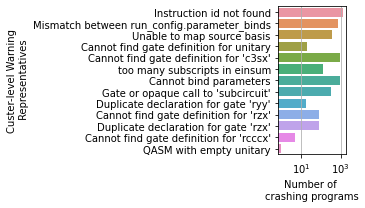

In [52]:
CLUSTERING_CONFIG = "cluster_v01"
from lib.inspector import cluster_warnings

cluster_config = load_config_and_check(
    f"../config/clustering/{CLUSTERING_CONFIG}.yaml")

df_crash_clustered = cluster_warnings(
    df=df_crash_both,
    warning_col="exceptions.followup",
    cluster_config=cluster_config,  
)
fig, ax = plt.subplots(figsize=(5, 3))
sns.countplot(
    data=df_crash_clustered,
    y="short_desc",
    ax=ax)
ax.set_ylabel("Custer-level Warning\n Representatives")
ax.set_xlabel("Number of \ncrashing programs")
ax.grid(axis='x')
ax.set_xscale('log')
plt.tight_layout()
fig.savefig(os.path.join(OUT_FOLDER, "warning_manual_clustering_categories.pdf"))

# RQ 3: QDiff vs MorphQ - Coverage

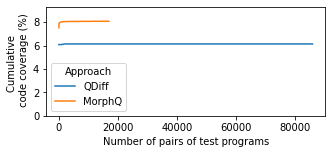

In [35]:
fig, ax = plt.subplots(figsize=(5, 2))

df_cov_both = pd.concat(df_all_cov, axis=0).reset_index()
df_cov_both = df_cov_both.rename(columns={"approach": "Approach"})
df_cov_both["Approach"] = df_cov_both["Approach"].map(
    {"qdiff": "QDiff", "morphq": "MorphQ"}
)


sns.lineplot(
    data=df_cov_both,
    x="n_programs",
    y="percent_covered",
    hue="Approach"
)
ax.set_ylabel("Cumulative \n code coverage (%)")
ax.set_xlabel("Number of pairs of test programs")
max_val = df_cov_both["percent_covered"].max()
ax.set_ylim(0, max_val * 1.15)
#ax.set_xscale('log')

fig.savefig(os.path.join(OUT_FOLDER, "coverage_morphq_vs_qdiff.pdf"))

# RQ 3: QDiff vs MorphQ - No. Warnings

QDiff brings no crash...
% comparison with qdiff
\newcommand{\totalCrashesMorphQ}{4,827}
\newcommand{\totalCrashesQDiff}{0}


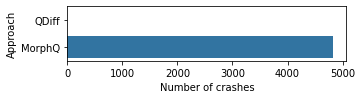

In [36]:
fig, ax = plt.subplots(figsize=(5, 1))
sns.countplot(
    data=df_crash_both,
    y="approach",
    ax=ax
)
ax.set_yticks(range(2))
ax.set_yticklabels(labels=["MorphQ", "QDiff"])

ax.set_ylim(-.5, 1.5)
ax.set_ylabel("Approach")
ax.set_xlabel("Number of crashes")
print("QDiff brings no crash...")

print("% comparison with qdiff")

total_crashes_morphq = len(df_crash_both[
    df_crash_both["approach"] == "morphq"
])
total_crashes_qdiff = len(df_crash_both[
    df_crash_both["approach"] == "qdiff"
])

print("\\newcommand{\\totalCrashesMorphQ}{"+f"{total_crashes_morphq:,.0f}"+"}")
print("\\newcommand{\\totalCrashesQDiff}{"+f"{total_crashes_qdiff:,.0f}"+"}")

# RQ 4: Contribution of MR to warnings

In [44]:
import ast

relevant_columns = [
    "program_id",
    "generated_a_crash",
    "exceptions.followup",
    "approach",
    COL_TRANSF,
    PVAL_COL
]
df = df_generated_programs_both[relevant_columns]
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(ast.literal_eval)
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(lambda e: list(set(e)))
df_flat = df.explode(COL_TRANSF)
df_flat.head()

/home/paltenmo/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,program_id,generated_a_crash,exceptions.followup,approach,followup.metamorphic_transformations,divergence.ks.p-value
0,46823057ae5e45c4ac08e5b167ae6f78,False,None,qdiff,ChangeBackend,1.000000
0,46823057ae5e45c4ac08e5b167ae6f78,False,None,qdiff,QdiffG1SwapToCnot,1.000000
1,9da73c1449834d808c382f2d40bfb8ad,False,None,qdiff,ChangeBackend,1.000000
1,9da73c1449834d808c382f2d40bfb8ad,False,None,qdiff,QdiffG1SwapToCnot,1.000000
2,0afaeffdcbfc41fa9fffa4538ead18ba,False,None,qdiff,ChangeOptLevel,0.997311


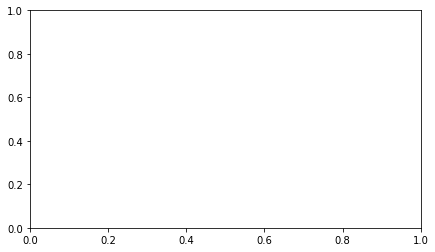

In [45]:
fig, ax = plt.subplots(figsize=(7, 4))

def assign_class(row):
    if row["generated_a_crash"]:
        return "Crash diff."
    else:
        if row[PVAL_COL] < ALPHA_LEVEL:
            return "Distrib. diff."
    return "Same"

def assign_class_short(row):
    if row["generated_a_crash"]:
        return "C"
    else:
        if row[PVAL_COL] < ALPHA_LEVEL:
            return "D"
    return "S"


df_flat["Execution comparison"] = df_flat.apply(
    lambda row: assign_class(row),
    #lambda row: assign_class_short(row),
    axis=1
)

df_flat[COL_TRANSF] = df_flat[COL_TRANSF].apply(
    lambda e: MR_ALIAS[e] if e in MR_ALIAS.keys() else e
)

## RQ 4.A: % of crashing programs withtransf A?

In [46]:
df_flat.head()

,program_id,generated_a_crash,exceptions.followup,approach,followup.metamorphic_transformations,divergence.ks.p-value,Execution comparison
0,46823057ae5e45c4ac08e5b167ae6f78,False,None,qdiff,Change of backend,1.000000,Same
0,46823057ae5e45c4ac08e5b167ae6f78,False,None,qdiff,QdiffG1SwapToCnot,1.000000,Same
1,9da73c1449834d808c382f2d40bfb8ad,False,None,qdiff,Change of backend,1.000000,Same
1,9da73c1449834d808c382f2d40bfb8ad,False,None,qdiff,QdiffG1SwapToCnot,1.000000,Same
2,0afaeffdcbfc41fa9fffa4538ead18ba,False,None,qdiff,Change of optimization level,0.997311,Same


In [47]:
map_mr_crash_perc = {}

df_morphq_flat = df_flat[df_flat["approach"] == "morphq"]

for mr_name in MR_ALIAS.values():
    df = df_morphq_flat
    df_c_mr = df[df["followup.metamorphic_transformations"] == mr_name]
    n_all_program_id = len(df_c_mr["program_id"].unique())    
    n_crashing_program_ids = len(df_c_mr[
        df_c_mr["Execution comparison"] == "Crash diff."
    ]["program_id"].unique())
    if n_all_program_id > 0 :
        perc_c_mr = (float(n_crashing_program_ids) / n_all_program_id) * 100
        print(f"{mr_name}: {perc_c_mr} %")
        map_mr_crash_perc[mr_name] = perc_c_mr
        


Change of gate set: 74.57813646368305 %
Roundtrip conversion via QASM: 59.617547806524186 %
Change of backend: 30.48910154173312 %
Change of coupling map: 26.84646031259577 %
Change of optimization level: 29.48614474038203 %
Change of qubit order: 3.7844940867279893 %
Partitioned execution: 0.0 %
Inject null-effect operations: 41.32324081861508 %
Add quantum register: 32.99583085169744 %
Inject parameters: 60.24369509776141 %


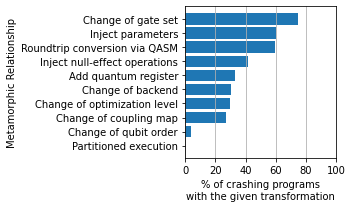

In [53]:
labels, perc = zip(*[
    (k, v) 
    for k, v in sorted(map_mr_crash_perc.items(), key=lambda item: item[1])])
fig, ax = plt.subplots(figsize=(5, 3))

ax.barh(
    width=perc,
    y=range(len(map_mr_crash_perc)),
    tick_label=labels
)
ax.grid(axis='x')
ax.set_xlim(0, 100)
ax.set_xlabel("% of crashing programs\nwith the given transformation")
ax.set_ylabel("Metamorphic Relationship")
plt.tight_layout()

fig.savefig(os.path.join(OUT_FOLDER, "contribution_of_mr_perc_crashes.pdf"))

## RQ 4.B: how many program with transf A crash, diverge, same?

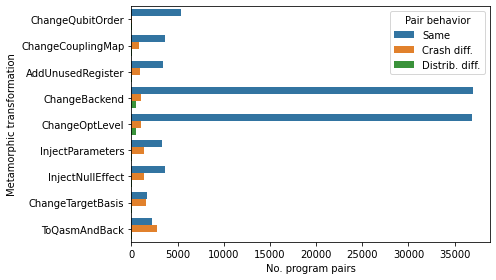

In [46]:
sns.countplot(
    data=df_flat,
    y=COL_TRANSF,
    order=df_flat[df_flat['Execution comparison'] == "Crash diff."][COL_TRANSF].value_counts(ascending=True).index,
    hue_order = ["Same", "Crash diff.", "Distrib. diff."],
    #order=df_flat[df_flat['Execution comparison'] == "C"][COL_TRANSF].value_counts(ascending=True).index,
    #hue_order = ["S", "C", "D"],
    hue='Execution comparison',
    #palette=["darkorange", "forestgreen", "dodgerblue"],
    ax=ax
)
ax.set_xlabel("No. program pairs")
ax.set_ylabel("Metamorphic transformation")
ax.legend(title="Pair behavior")
plt.tight_layout()
#fig.savefig(os.path.join(OUT_FOLDER, "RQ3_quantitative_most_crashing_MR_medium.pdf"))

## RQ 4: contrib. to crashes vs no. MR applied

In [88]:
df = df_generated_programs_both.copy()

df_generated_programs_morphq_w_no_MR = df[df["approach"] == "morphq"]

df_generated_programs_morphq_w_no_MR["ast_list_MR"] = \
    df_generated_programs_morphq_w_no_MR[COL_TRANSF].apply(ast.literal_eval)
df_generated_programs_morphq_w_no_MR["no_MR_applied"] = \
    df_generated_programs_morphq_w_no_MR["ast_list_MR"].apply(lambda e: len(list(e)))

df_generated_programs_morphq_w_no_MR = df_generated_programs_morphq_w_no_MR.reset_index(drop=True)

/tmp/ipykernel_11641/1936597909.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_generated_programs_morphq_w_no_MR["ast_list_MR"] = \
/tmp/ipykernel_11641/1936597909.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_generated_programs_morphq_w_no_MR["no_MR_applied"] = \


In [89]:
df_generated_programs_morphq_w_no_MR[["program_id", "no_MR_applied"]].head()

,program_id,no_MR_applied
0,4970e2b104cd4b628ab2f1679fc97130,3
1,b58558c98d474247b0d29dafce4bc6d8,1
2,aa0c6761fbf547b2897c6304d8cbb944,1
3,4c7350aae20348778b91bd71320b7da0,3
4,bbd33738c6a645f58fa1adb460db3f71,2


<AxesSubplot:xlabel='no_MR_applied', ylabel='Count'>

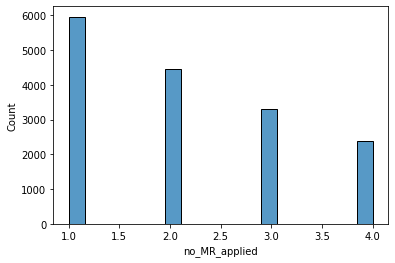

In [91]:
sns.histplot(
    data=df_generated_programs_morphq_w_no_MR,
    x="no_MR_applied"
)

In [105]:
# save a list of all programs in the four categories

map_no_MR_to_prog_ids = {}

for i in range(1, 5):
    programs_with_i_MR = df_generated_programs_morphq_w_no_MR[
        df_generated_programs_morphq_w_no_MR["no_MR_applied"] == i
    ]["program_id"].unique()
    map_no_MR_to_prog_ids[i] = list(programs_with_i_MR)

In [106]:
map_no_MR_to_prog_ids

{1: ['b58558c98d474247b0d29dafce4bc6d8',
  'aa0c6761fbf547b2897c6304d8cbb944',
  '8c16baf890bf47f99f790d259b0348fd',
  '97cfc75d09864133b9953b7c0c261955',
  '49e6b0fcf5124589a851c48ac4193122',
  '702fb72e5e20438788ff786cddfb0ff3',
  'f22b5cceb0194fbeabf070032522ed76',
  '8ff17db14fb14442924f54cdbebe4d01',
  '2fb26e288dc14be395a23c9cdd10c145',
  '99c29467bbb34305ad7c501d74fee81d',
  '81c396d91ef9474b8f3e1f68c01ba491',
  '0fac9a8a90654316b7d8a01461996d39',
  '0c6db2f7c1964961b2f8f7cbc306e004',
  'ace4e6aec4f541ccbb5005cf3c272ee8',
  '358dfe80cf5c43b29b0b4c055339f74b',
  'e8f06c2172da4cf1b1699b54f799673f',
  'd0c39cdb31c04339ba6d5acd0f3caede',
  'c9e08055cafe4d87ada1215e76b558db',
  'ee44a3df12764173b29ba9f098632055',
  '281ca733429f4a81af76d2d54ef80e12',
  'c7dff33496854553b17aebfee432b51b',
  '60a5dc5ee6af4fc19eaf117bddc14071',
  '3e388487bbf74a0a9d80e1e6a0c78d49',
  'd2bb210280624293a09ca11106941d80',
  'd1b6713386844ec4aed229729279f411',
  'c173b44cd73d4295b711078c6d5aa31d',
  'f31ecf

Change of gate set: 73.35243553008596 %
Roundtrip conversion via QASM: 49.37238493723849 %
Change of backend: 0.0 %
Change of coupling map: 0.0 %
Change of optimization level: 0.0 %
Change of qubit order: 0.0 %
Partitioned execution: 0.0 %
Inject null-effect operations: 9.381663113006397 %
Add quantum register: 0.0 %
Inject parameters: 47.02127659574468 %
Change of gate set: 72.30046948356808 %
Roundtrip conversion via QASM: 50.916936353829556 %
Change of backend: 15.789473684210526 %
Change of coupling map: 14.093264248704662 %
Change of optimization level: 15.242718446601941 %
Change of qubit order: 4.774774774774775 %
Partitioned execution: 0.0 %
Inject null-effect operations: 26.266804550155122 %
Add quantum register: 21.108742004264393 %
Inject parameters: 55.379388448471126 %
Change of gate set: 73.37209302325581 %
Roundtrip conversion via QASM: 60.73943661971831 %
Change of backend: 35.2363960749331 %
Change of coupling map: 31.818181818181817 %
Change of optimization level: 33.

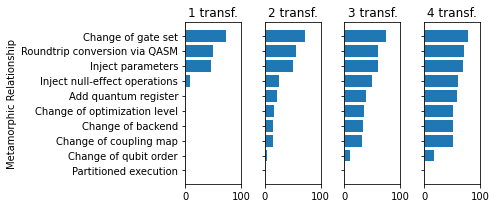

In [111]:
fig, axes = plt.subplots(1, 4, figsize=(7, 3), sharey=True)

for i in range(4):
    ax_i = axes[i]
    ids_prog_to_consider = map_no_MR_to_prog_ids[i+1]
    
    
    # compute the contributions per each MR
    map_mr_crash_perc = {}

    df_morphq_flat = df_flat[df_flat["approach"] == "morphq"]
    df_morphq_flat = df_morphq_flat[
        df_morphq_flat["program_id"].isin(ids_prog_to_consider)
    ]
    
    for mr_name in MR_ALIAS.values():
        df = df_morphq_flat
        df_c_mr = df[df["followup.metamorphic_transformations"] == mr_name]
        n_all_program_id = len(df_c_mr["program_id"].unique())    
        n_crashing_program_ids = len(df_c_mr[
            df_c_mr["Execution comparison"] == "Crash diff."
        ]["program_id"].unique())
        if n_all_program_id > 0 :
            perc_c_mr = (float(n_crashing_program_ids) / n_all_program_id) * 100
            print(f"{mr_name}: {perc_c_mr} %")
            map_mr_crash_perc[mr_name] = perc_c_mr
    
    # plot 
    labels, perc = zip(*[
        (k, v) 
        for k, v in sorted(map_mr_crash_perc.items(), key=lambda item: item[1])])

    ax_i.barh(
        width=perc,
        y=range(len(map_mr_crash_perc)),
        tick_label=labels
    )
    ax_i.set_title(f"{i+1} transf.")
    ax_i.grid(axis='x')
    ax_i.set_xlim(0, 100)


axes[0].set_ylabel("Metamorphic Relationship")
#axes.set_xlabel("% of crashing programs\nwith the given transformation")
plt.tight_layout()

#fig.savefig(os.path.join(OUT_FOLDER, "contribution_of_mr_perc_crashes_no_MR_applied.pdf"))

# RQ 5: Time Analysis

In [39]:
relevant_time_cols = [
    'program_id',
    'time_exec',
    'source.time_generation',
    #'followup.time_generation', # this attribute is statically copied form source
    'followup.time_metamorph',
    #'divergence.ks.time',
    'generated_a_crash'
]

df_time = df_morphq[relevant_time_cols]
df_time.head()

,program_id,time_exec,source.time_generation,followup.time_metamorph,generated_a_crash
41390,4970e2b104cd4b628ab2f1679fc97130,0.273039,0.003070,0.019112,False
41391,b58558c98d474247b0d29dafce4bc6d8,0.279585,0.005049,0.012121,False
41392,aa0c6761fbf547b2897c6304d8cbb944,0.629534,0.006912,0.017171,False
41393,4c7350aae20348778b91bd71320b7da0,0.316712,0.005396,0.020348,False
41394,bbd33738c6a645f58fa1adb460db3f71,0.331670,0.005592,0.024027,False


In [40]:
df_time_melt = pd.melt(
    df_time, id_vars=['program_id', 'generated_a_crash'], 
    value_vars=relevant_time_cols.remove('program_id'))
df_time_melt["value"] = df_time_melt["value"].apply(lambda e: 1000 * e)
df_time_melt.head(20)

,program_id,generated_a_crash,variable,value
0,4970e2b104cd4b628ab2f1679fc97130,False,time_exec,273.038936
1,b58558c98d474247b0d29dafce4bc6d8,False,time_exec,279.584617
2,aa0c6761fbf547b2897c6304d8cbb944,False,time_exec,629.534383
3,4c7350aae20348778b91bd71320b7da0,False,time_exec,316.712191
4,bbd33738c6a645f58fa1adb460db3f71,False,time_exec,331.670488
5,f6ef44abdadb4f0192cad82d2b8946b8,False,time_exec,387.116068
6,af86926cb53948e08570f44fb3a0e0fb,False,time_exec,316.312997
7,9958cc5eff7543e3b4d6fd6896a2fa99,False,time_exec,447.357050
8,42d5c704522c45c792967966fd24401d,False,time_exec,532.507704
9,8c16baf890bf47f99f790d259b0348fd,False,time_exec,364.289880


% RQ3
\newcommand{\avgTimeMsGenerationAndTransf}{33.6}
\newcommand{\avgTimeMsGenerationOnly}{5.7}
\newcommand{\avgTimeMsTransfOnly}{27.9}


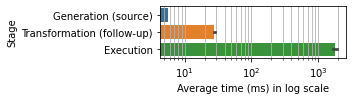

In [42]:
fig, ax = plt.subplots(figsize=(5, 1.5))

mapping = {
    "source.time_generation": 'Generation (source)',
    "followup.time_metamorph": 'Transformation (follow-up)',
    "time_exec": "Execution",
    #"divergence.ks.time": "Divergence Check"
}

sns.barplot(
    data=df_time_melt,
    y='variable',
    x='value',
    order=list(mapping.keys()),
    ax=ax
)

print("% RQ3")
avg_ms_gen_and_transf = df_time_melt[df_time_melt["variable"].isin([
    "source.time_generation", 
    "followup.time_metamorph"]
)].groupby(by="program_id").sum().reset_index()["value"].mean()
print("\\newcommand{\\avgTimeMsGenerationAndTransf}{" + f"{avg_ms_gen_and_transf:.1f}" + "}")

avg_ms_gen_only = df_time_melt[
    df_time_melt["variable"] == "source.time_generation"].reset_index()["value"].mean()
print("\\newcommand{\\avgTimeMsGenerationOnly}{" + f"{avg_ms_gen_only:.1f}" + "}")
avg_ms_transf_only = df_time_melt[
    df_time_melt["variable"] == "followup.time_metamorph"].reset_index()["value"].mean()
print("\\newcommand{\\avgTimeMsTransfOnly}{" + f"{avg_ms_transf_only:.1f}" + "}")

original_labels = ax.get_yticklabels()
ax.set_yticklabels(labels=[
    mapping.get(e._text, e._text)
    for e in original_labels
])
ax.grid(axis='x', which='both')
ax.set_xscale('log')
ax.set_ylabel('Stage')
ax.set_xlabel('Average time (ms) in log scale')

plt.tight_layout()
fig.savefig(os.path.join(OUT_FOLDER, "RQ4_time_analysis.pdf"))

# Miscellanea

In [22]:
PVAL_COL = "divergence.ks.p-value"
COL_TRANSF = "followup.metamorphic_transformations"

relevant_columns = [
    "program_id",
    "generated_a_crash",
    "exceptions.followup",  
    "approach",
    "experiment_name",
    COL_TRANSF,
    PVAL_COL
]
df = df_generated_programs_both[relevant_columns]
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(ast.literal_eval)
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(lambda e: list(set(e)))
df_flat = df.explode(COL_TRANSF)
df_flat.head()

/home/paltenmo/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,program_id,generated_a_crash,exceptions.followup,approach,experiment_name,followup.metamorphic_transformations,divergence.ks.p-value
0,1fae8c7324474de286c972ed7a6f70f6,False,None,qdiff,qmt_v30,QdiffG7CCNOTDecomposition,0.999809
0,1fae8c7324474de286c972ed7a6f70f6,False,None,qdiff,qmt_v30,ChangeOptLevel,0.999809
1,d555c1298ccc4dcb8475b1b83312a4b6,False,None,qdiff,qmt_v30,ChangeBackend,1.000000
1,d555c1298ccc4dcb8475b1b83312a4b6,False,None,qdiff,qmt_v30,QdiffG1SwapToCnot,1.000000
2,e31493f1cbbb40c88e5e0d194c3137e5,False,None,qdiff,qmt_v30,QdiffG7CCNOTDecomposition,1.000000


In [23]:
df = df_generated_programs_both[relevant_columns]
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(ast.literal_eval)
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(lambda e: list(set(e)))
df = df[relevant_columns]
for mr_name in ALL_MR_NAMES:
    df[mr_name] = df['followup.metamorphic_transformations'].apply(
        lambda list_mr_transf: int(mr_name in list_mr_transf)
    )
df_one_hot_transformations = df

/home/paltenmo/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [24]:
import scipy

def get_entropy_on_column(df: pd.DataFrame, column_name: str):
    """Compute the entropy on a binary column."""
    tot = len(df)
    prob_positive_class = float(len(df[df[column_name] == True])) / tot
    prob_negative_class = float(len(df[df[column_name] == False])) / tot
    print("prob_positive_class: ", prob_positive_class)
    print("prob_negative_class: ", prob_negative_class)
    entropy = scipy.stats.entropy(
        [prob_positive_class, prob_negative_class] , base=2)
    return entropy, prob_positive_class, prob_negative_class

In [122]:
import scipy


entropies_per_mr = []
mr_names = []
all_perc_crashes = []

for c_feature in ALL_MR_NAMES:
    df = df_one_hot_transformations
    
    print("---------------------------------")
    print("MR: ", c_feature)
    try:
        df_w_feature = df[df[c_feature] == 1]
        df_no_feature = df[df[c_feature] == 0]
    except:
        print("MR not present in this experiment")
        continue

    entropy_w_feature, perc_crashes, _ = get_entropy_on_column(
        df=df_w_feature, column_name="generated_a_crash")
    all_perc_crashes.append(int(perc_crashes * 100))
    print("- entropy_w_MR: ", entropy_w_feature)
    print("len(df_w_feature): ", len(df_w_feature))
    entropies_per_mr.append(entropy_w_feature)
    mr_names.append(c_feature)
    
    entropy_no_feature = get_entropy_on_column(
        df=df_no_feature, column_name="generated_a_crash")
    print("- (entropy_no_MR: ", entropy_no_feature, ")")
    


---------------------------------
MR:  AddUnusedRegister
prob_positive_class:  0.30664240218380345
prob_negative_class:  0.6933575978161965
- entropy_w_MR:  0.8892595943994607
len(df_w_feature):  1099
prob_positive_class:  0.11543895055499495
prob_negative_class:  0.884561049445005
- (entropy_no_MR:  (0.5161065784480586, 0.11543895055499495, 0.884561049445005) )
---------------------------------
MR:  ChangeBackend
prob_positive_class:  0.08706345302508608
prob_negative_class:  0.9129365469749139
- entropy_w_MR:  0.426591298014204
len(df_w_feature):  4066
prob_positive_class:  0.16232176292668876
prob_negative_class:  0.8376782370733112
- (entropy_no_MR:  (0.6398351288083474, 0.16232176292668876, 0.8376782370733112) )
---------------------------------
MR:  ChangeCouplingMap
prob_positive_class:  0.2655038759689923
prob_negative_class:  0.7344961240310077
- entropy_w_MR:  0.8349387363681458
len(df_w_feature):  1032
prob_positive_class:  0.12097824997494237
prob_negative_class:  0.8790217

ZeroDivisionError: float division by zero

Text(0.5, 0, 'Entropy of warnings-inducing')

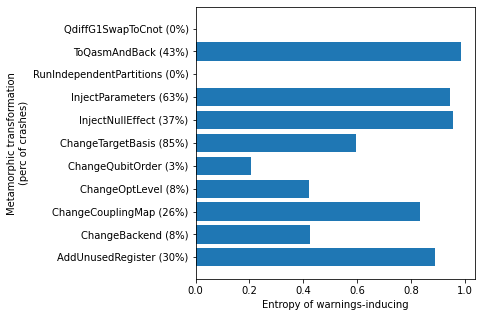

In [124]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.barh(
    y=range(len(mr_names)),
    width=entropies_per_mr,
    tick_label=[
        f"{n} ({p}%)" 
        for n, p in zip(mr_names, all_perc_crashes)]
)
ax.set_ylabel("Metamorphic transformation\n(perc of crashes)")
ax.set_xlabel("Entropy of warnings-inducing")

## Random Forest: predict the crash from the MR applied

In [89]:
from sklearn.ensemble import RandomForestClassifier

X = df_one_hot_transformations[mr_names]
y = df_one_hot_transformations["generated_a_crash"]

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

In [90]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.barh(
    y=range(len(mr_names)),
    width=clf.feature_importances_,
    tick_label=mr_names
)
ax.set_ylabel("Metamorphic transformation")
ax.set_xlabel("Feature Importance")



array([0.00410449, 0.00138093, 0.0011641 , 0.00070822, 0.1955969 ,
       0.37339998, 0.0386243 , 0.25159942, 0.0246098 , 0.09828576,
       0.00333062, 0.00719547])

In [ ]:
clf.predict([[0, 0, 0, 0]]))